# 2023년 KBO리그 방송국별 선호하는 팀 조사

2023년 LG 트윈스의 경기는 유독 SPOTV 중계가 많이 걸렸다.

LG 트윈스가 SPOTV의 사랑을 듬뿍 받는지, MBC 스포츠플러스는 KIA나 롯데 경기가 대부분일지 확인해 보자.

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

In [3]:
driver = webdriver.Chrome()
driver.get("https://www.koreabaseball.com/Schedule/Schedule.aspx")


In [8]:
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from tqdm.auto import tqdm

timetables = []

for i in tqdm(["04", "05", "06", "07", "08", "09", "10"]):
    dropdownA = Select(driver.find_element(By.ID, 'ddlYear'))
    dropdownA.select_by_value("2023")
    dropdownB = Select(driver.find_element(By.ID, 'ddlMonth'))
    dropdownB.select_by_value(i)
    table = driver.find_element(By.ID, 'tblScheduleList')
    rows = table.find_elements(By.TAG_NAME, 'tr')
    data = []
    current = ""
    for r in tqdm(rows):
        row_data = []
        cells = r.find_elements(By.TAG_NAME, 'td')
        if cells:
            try:
                if cells[0].get_attribute("rowspan"):
                    current = cells[0].text
                    row_data.append(current)
                    row_data.append(cells[2].text)
                    row_data.append(cells[5].text)
                    row_data.append(cells[8].text)
                else:
                    row_data.append(current)
                    row_data.append(cells[1].text)
                    row_data.append(cells[4].text)
                    row_data.append(cells[7].text)
            except:
                pass
            data.append(row_data)
        
    table = pd.DataFrame(data, columns=["일시", "경기", "TV", "취소"])
    timetables.append(table)
    
df = pd.concat(timetables, ignore_index=True)
df



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

,일시,경기,TV,취소
0,04.01(토),롯데10vs12두산,S-T,-
1,04.01(토),KIA1vs4SSG,M-T,-
2,04.01(토),NC8vs0삼성,SS-T\nKN-T,-
3,04.01(토),LG6vs11KT,SPO-2T\nSPO-T\nMS-T,-
4,04.01(토),한화2vs3키움,K-2T,-
...,...,...,...,...
808,10.16(월),SSG3vs2두산,SPO-2T,-
809,10.16(월),NC2vs4KIA,MS-T\nSS-T,-
810,10.16(월),롯데7vs2한화,SPO-T\nKN-T,-
811,10.17(화),두산0vs5SSG,SPO-2T,-


In [186]:
driver.quit()

In [100]:
from fractions import Fraction

def divide(row):
    return Fraction(1, row['count'])

df_proc = df.copy()[~(df['취소'] != "-")]
df_proc = df_proc.reset_index(drop=True)
df_proc["경기번호"] = df_proc.index + 1
df_proc[["원정", "홈"]] = df_proc["경기"].str.extract(r"([가-힣A-Z]+)\d+vs\d+([가-힣A-Z]+)")
df_proc["TV"] = df_proc["TV"].str.replace("네이버\nDaum카카오\nTVING\nwavve\n스포키", "중계없음")
df_proc["TV"] = df_proc["TV"].str.split("\n")
df_proc = df_proc.drop(["경기", "취소"], axis=1)
df_proc = df_proc.explode('TV', ignore_index=True)
df_proc = pd.melt(df_proc, id_vars=["일시", "TV", "경기번호"], var_name="구분", value_name="팀")
df_proc = df_proc.drop("구분", axis=1)
df_proc["score"] = 2 / df_proc.groupby('경기번호')["팀"].transform("count")
df_proc

,일시,TV,경기번호,팀,score
0,04.01(토),S-T,1,롯데,1.000000
1,04.01(토),M-T,2,KIA,1.000000
2,04.01(토),SS-T,3,NC,0.500000
3,04.01(토),KN-T,3,NC,0.500000
4,04.01(토),SPO-2T,4,LG,0.333333
...,...,...,...,...,...
1619,10.16(월),SS-T,717,KIA,0.500000
1620,10.16(월),SPO-T,718,한화,0.500000
1621,10.16(월),KN-T,718,한화,0.500000
1622,10.17(화),SPO-2T,719,SSG,1.000000


In [101]:
df_proc.to_pickle("baseball_data.pkl")

In [102]:
pd.read_pickle("baseball_data.pkl")

,일시,TV,경기번호,팀,score
0,04.01(토),S-T,1,롯데,1.000000
1,04.01(토),M-T,2,KIA,1.000000
2,04.01(토),SS-T,3,NC,0.500000
3,04.01(토),KN-T,3,NC,0.500000
4,04.01(토),SPO-2T,4,LG,0.333333
...,...,...,...,...,...
1619,10.16(월),SS-T,717,KIA,0.500000
1620,10.16(월),SPO-T,718,한화,0.500000
1621,10.16(월),KN-T,718,한화,0.500000
1622,10.17(화),SPO-2T,719,SSG,1.000000


# 각 방송사의 팀별 중계 횟수

* 같은 경기를 여러 방송사가 중계한 경우에도 1회로 간주한다.
* 홈, 원정은 구분하지 않는다.
* 취소된 경기는 제외한다.
* 합이 144경기가 아닌 이유: 각 팀은 144경기를 뛰지만, 실제로 우천취소나 잔여경기 등을 고려했을 때 1년에 야구를 하는 날은 144일 이상이다.

In [54]:
broadcasters = df_proc['TV'].unique()
broadcasters

result = dict()

for b in broadcasters:
    result[b] = df_proc.loc[df_proc["TV"]==b, "팀"].value_counts()
    result[b] = result[b].reindex(index = ["LG", "KT", "SSG", "NC", "두산", "KIA", "롯데", "삼성", "한화", "키움"])
    result[b] = result[b].fillna(0)

In [55]:
result["SPO"] = result["SPO-2T"] + result["SPO-T"]
result["SPO"] = result["SPO"].reindex(index = ["LG", "KT", "SSG", "NC", "두산", "KIA", "롯데", "삼성", "한화", "키움"])

In [168]:
result["KMS"] = result["K-2T"] + result["M-T"] + result["S-T"]
result["KMS"] = result["KMS"].reindex(index = ["LG", "KT", "SSG", "NC", "두산", "KIA", "롯데", "삼성", "한화", "키움"])

In [169]:
result.keys()

dict_keys(['S-T', 'M-T', 'SS-T', 'KN-T', 'SPO-2T', 'SPO-T', 'MS-T', 'K-2T', '중계없음', 'G-CMB', 'D-CMB', 'SPO', 'KMS'])

In [170]:
b_names = {"SPO": "SPOTV 및 SPOTV-2", "MS-T": "MBC Sports+", "KN-T": "KBS N Sports", "SS-T": "SBS Sports",
           "SPO-T": "SPOTV", "SPO-2T": "SPOTV-2", "S-T": "SBS(지상파)", "M-T": "MBC(지상파)", "K-2T": "KBS2(지상파)",
           "G-CMB": "CMB광주방송", "D-CMB": "CMB대전방송", "중계없음": "중계없음(OTT)", "KMS": "지상파(KBS2 + MBC + SBS)"}

In [ ]:
b_names.values()

In [64]:
result['중계없음']

LG     0.0
KT     2.0
SSG    2.0
NC     1.0
두산     1.0
KIA    0.0
롯데     2.0
삼성     2.0
한화     0.0
키움     2.0
Name: 팀, dtype: float64

In [183]:
import pickle
with open(file="resultA.pickle", mode="wb") as f:
    pickle.dump(result, f)
    
import pickle
with open(file="resultA.pickle", mode="rb") as f:
    result = pickle.load(f)

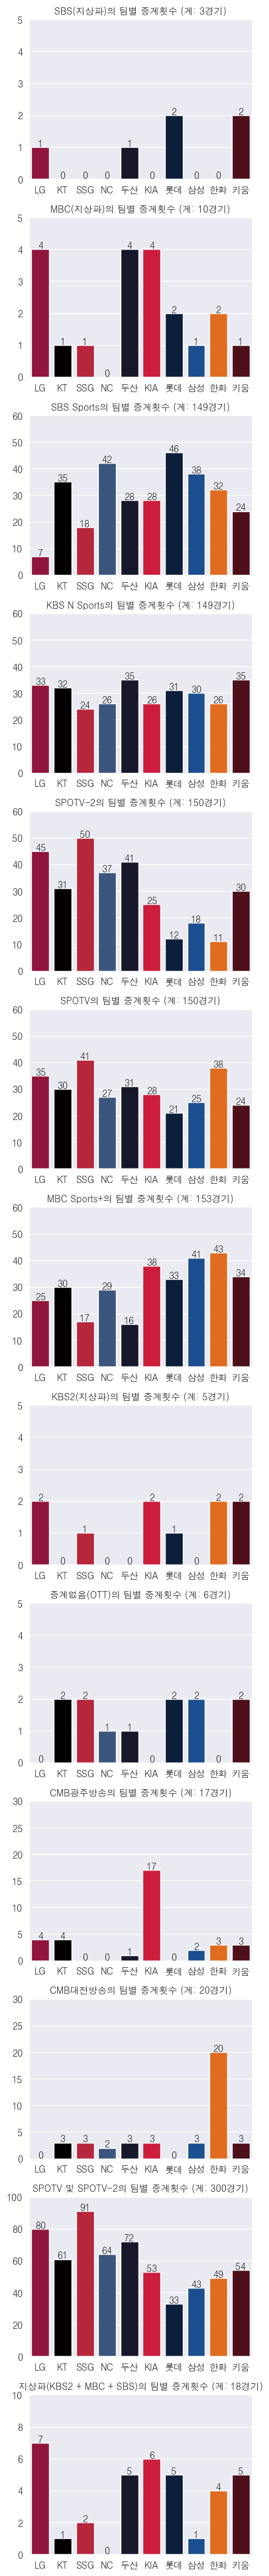

In [173]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

rc('font', family='Dotum')
custom_palette = {"LG": (165, 0, 52), 'KT': (0, 0, 0), "SSG": (206, 14, 45), "NC": (49, 82, 136), "두산": (19, 19, 48),
                  "KIA": (234, 0, 41), "롯데": (4, 30, 66), "삼성": (7, 76, 161), "한화": (255, 102, 0), "키움": (87, 5, 20)}
custom_palette = {key: tuple(map(lambda x: x / 255, value)) for key, value in custom_palette.items()}

fig, ax = plt.subplots(13, 1, figsize=(4, 39))

ax = ax.flatten()
for idx, b in enumerate(result.keys()):
    sns.barplot(x=result[b].index, y=result[b].values, palette=result[b].index.map(custom_palette), ax=ax[idx])
    
    if b == "SPO":
        ax[idx].set_ylim([0, 100])
    elif b in ["G-CMB", "D-CMB"]:
        ax[idx].set_ylim([0, 30])
    elif b == "KMS":
        ax[idx].set_ylim([0, 10])
    elif b in ["M-T", "S-T", "K-2T", "중계없음"]:
        ax[idx].set_ylim([0, 5])
    else:
        ax[idx].set_ylim([0, 60])
    ax[idx].set_title(f"{b_names[b]}의 팀별 중계횟수 (계: {int(sum(result[b]) / 2)}경기)", fontsize=10)
    
    for p in ax[idx].patches:
        ax[idx].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points', fontsize=10)
    ax[idx].set_xticklabels(ax[idx].get_xticklabels(), fontsize=10)
    ax[idx].tick_params(axis='y', labelsize=10)
        
plt.subplots_adjust(hspace=4)
plt.tight_layout()
sns.set_style("darkgrid")
plt.show()

# 각 팀의 중계방송 방송국 비율

* 경기수: 같은 경기를 n개의 방송사가 중계한 경우에도 각각 1회로 간주한다. (총합이 144경기가 아닐 수 있음)
* 비율: 같은 경기를 n개의 방송사가 중계한 경우에는 1/n회로 간주한다. (총합은 144경기)
* 홈, 원정은 구분하지 않는다.
* 취소된 경기는 제외한다.
* 라디오 중계는 제외한다.

In [133]:
teams = df_proc["팀"].unique()
result2 = dict()
for t in teams:
    result2[t] = pd.DataFrame(index = broadcasters, columns=["경기수", "비율점수"])
    result2[t]["경기수"] = df_proc[df_proc["팀"]==t].groupby('TV')['score'].count()
    result2[t]["비율점수"] = df_proc[df_proc["팀"]==t].groupby('TV')['score'].sum()
    result2[t] = result2[t].rename(index=b_names)
    result2[t] = result2[t].sort_values("경기수", ascending=False)
    result2[t] = result2[t].fillna(0)
    result2[t]["경기수"] = result2[t]["경기수"].astype(int)


In [134]:
result2["SSG"]

,경기수,비율점수
SPOTV-2,50,47.333333
SPOTV,41,37.500000
KBS N Sports,24,22.500000
SBS Sports,18,14.833333
MBC Sports+,17,16.333333
CMB대전방송,3,1.500000
중계없음(OTT),2,2.000000
MBC(지상파),1,1.000000
KBS2(지상파),1,1.000000
SBS(지상파),0,0.000000


In [185]:
import pickle
with open(file="resultB.pickle", mode="wb") as f:
    pickle.dump(result2, f)
    
import pickle
with open(file="resultB.pickle", mode="rb") as f:
    result2 = pickle.load(f)

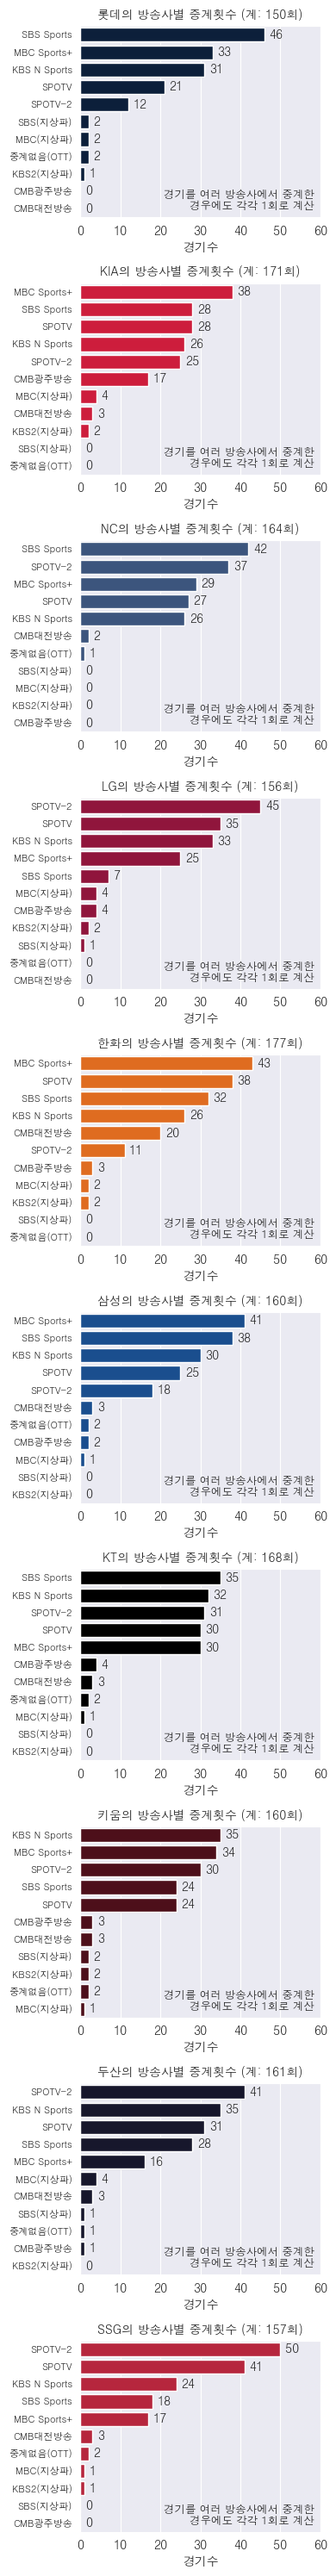

In [156]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

rc('font', family='Dotum')

fig, ax = plt.subplots(10, 1, figsize=(4, 30))

ax = ax.flatten()
for idx, t in enumerate(teams):
    sns.barplot(y=result2[t].index, x=result2[t]["경기수"], color=custom_palette[t], ax=ax[idx])
    ax[idx].set_xlim([0, 60])
    ax[idx].set_title(f"{t}의 방송사별 중계횟수 (계: {result2[t]['경기수'].sum()}회)", fontsize=10)
    
    for p in ax[idx].patches:
        ax[idx].annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(4, 0), textcoords='offset points', fontsize=10)
    ax[idx].annotate('경기를 여러 방송사에서 중계한\n 경우에도 각각 1회로 계산', xy=(1, 0), xycoords='axes fraction', fontsize=9,
            xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')
    ax[idx].set_yticklabels(ax[idx].get_yticklabels(), fontsize=8)
    ax[idx].tick_params(axis='x', labelsize=10)
        
plt.subplots_adjust(hspace=4)
plt.tight_layout()
sns.set_style("darkgrid")
plt.show()